# 1. KBO 타자 OPS 예측

## 1.1 문제 정의
### 1.1.1 경진대회 소개

![경진대회소개 이미지](img/1.png)
![경진대회 개요](img/2.png)

![경진대회 배경](img/3.png)

### 1.1.2 평가척도

평가척도: 참가자가 최종적으로 제출한 결과물의 우열을 판단하는 구체적인 방식.

이 대회에서는
WRMSE(Weighted Root Mean Squeare Error) 라는 평가척도를 적용함.

WRMSE는 실제값과 예측값의 차이를 계산하되 특정한 방식으로 가중치를 부여함.

![경진대회 배경](img/4.png)
기본적으로 실제값과 예측값의 차이를 기준으로 평가하므로 오차가 작을수록 좋음.

타자들의 OPS를 예측할 때 비주전 선수의 성적보다는 주전 선수의 성적을 예측하는 것이 더 중요하다. WRMSE는 이러한 경향을 반영하는 평가척도라고 볼 수 있다.

-> 많은 타수를 기록한 선수가 적은 타수를 기록한 선수보다 WRMSE에 크게 기여함.

-> 한 경기에도 타석에 들어서지 못한 선수들은 가중치가 0이므로 계산 결과도 0이 된다.

![WRMSE 평가 예시](img/5.png)

* WRMSE는 숫자가 작을수록 좋은 결과라고 평가하는 척도.

* 타수가 낮은 선수의 성적이 WRMSE에 미치는 영향이 작음을 고려할 때, 경기를 많이 뛰는 선수들에 대해 예측을 잘 하는 것이 WRMSE의 값을 낮추는 데 더 중요하다는 것을 알 수 있다.

### 1.1.3 도메인 조사

* 도메인 지식: 데이터 분석 대상이 되는 분야의 지식

-> 수준 높은 데이터 분석을 위해 도메인 지식은 매우 중요하다.

-----------------------------

* 정규시즌 경기: 우리가 흔히 알고 있는 프로스포츠 경기.

-> 정규시즌에서의 승패 등의 성적이 쌓여 각 구단의 최종 순위가 결정됨.

* 시범경기: 정규시즌 시작 전에 열리는 비공식 경기.

-> 최종 순위에 영향을 미치지는 않지만 경기 자체는 정규시즌과 똑같은 방식으로 진행됨.

=> 예측 대상이 되는 타자의 OPS는 정규시즌의 성적.

-----------------------------

* 상반기, 하반기
-> 2019년은 7월 18일을 상반기의 기준으로 삼았음.

-----------------------------

* OPS (On base Plus Skugging)
: 타자들의 여러 성적을 종합하여 계산하는 척도.
-> 타자의 출루율(OBP) + 장타율(SLG)를 더해 계산 가능


![분석에 필요한 주요 야구 용어](img/6.png)

### 1.1.5 분석 환경 구축
[ 분석에 사용한 라이브러리 소개 ]
* numpy : 행렬이나 대규모 다차원 배열을 처리할 수 있게 지원함.

* pandas : Dataframe 형태 데이터의 조작 및 분석을 위해 파이썬 언어로 작성된 소프트웨어 라이브러리.

* seaborn : matplotlib이라는 기존 라이브러리를 기반으로 좀 더 다양한 그래프를 작성할 수 있음.

* sklearn : 파이썬에서 많이 쓰이는 머신러닝 기능을 제공함.

* xgboost : XGBoost 모델을 불러오기 위해 사용됨.

## 1.2. 탐색적 데이터 분석

* 탐색적 데이터 분석: 전반적으로 데이터를 이해하기 위한 데이터 탐색 과정

-> 데이터의 분포 및 특성 등에 대한 정보를 파악하고 데이터 간의 관계를 확인

-> 탐색적 데이터 분석에서 양질의 정보를 얻어 이를 예측 모델링과 전처리에 활용한다.

In [1]:
# 시각화를 위한 한글 폰트 표시 작업을 위해 다음 코드를 실행한다.
# 필요 라이브러리 로드
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np
import platform

if platform.system() == 'Windows':
    # 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="C:\Windows\Fonts\malgun.ttf").get_name()
    rc('font', family=font_name, size=8)

# Mac인 경우
else:
    rc('font', family='AppleGothic', size=8)

# 그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
matplotlib.rcParams['axes.unicode_minus'] = False

### 1.2.1. 프리시즌 데이터 분석

In [2]:
# 프리시즌 데이터 로드
preseason_df = pd.read_csv('data/Pre_Season_Batter.csv')

# 정규시즌 데이터 로드
regular_season_df = pd.read_csv('data/Regular_Season_Batter.csv')

# 데이터 크기 확인
print(preseason_df.shape)

(1393, 29)


In [3]:
# 데이터 상단 출력
# display(preseason_df.head())
preseason_df.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,...,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493


In [4]:
preseason_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393 entries, 0 to 1392
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   batter_id        1393 non-null   int64  
 1   batter_name      1393 non-null   object 
 2   year             1393 non-null   int64  
 3   team             1393 non-null   object 
 4   avg              1393 non-null   object 
 5   G                1393 non-null   int64  
 6   AB               1393 non-null   int64  
 7   R                1393 non-null   int64  
 8   H                1393 non-null   int64  
 9   2B               1393 non-null   int64  
 10  3B               1393 non-null   int64  
 11  HR               1393 non-null   int64  
 12  TB               1393 non-null   int64  
 13  RBI              1393 non-null   int64  
 14  SB               1393 non-null   int64  
 15  CS               1393 non-null   int64  
 16  BB               1393 non-null   int64  
 17  HBP           

In [5]:
# 데이터 기초통계량 확인
# display(preseason_df.describe())
preseason_df.describe()

,batter_id,year,G,AB,R,H,2B,3B,HR,TB,...,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,...,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1364.000000,1368.000000,1393.000000,1364.000000
mean,173.434314,2013.014358,8.705671,19.201723,2.679828,5.021536,0.954774,0.119885,0.391960,7.391960,...,0.629576,0.291457,1.877961,0.330223,3.714286,0.447236,0.361012,0.317912,0.381910,0.676924
std,94.716851,4.166757,5.562686,13.395946,2.637212,4.232584,1.196904,0.379976,0.748557,6.538787,...,1.146854,0.595522,2.053392,0.642204,3.180884,0.723364,0.269892,0.151489,0.729521,0.386933
min,0.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.000000,2010.000000,6.000000,9.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.217000,0.250000,0.000000,0.472000
50%,178.000000,2014.000000,9.000000,18.000000,2.000000,4.000000,1.000000,0.000000,0.000000,6.000000,...,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.344500,0.333000,0.000000,0.675000
75%,254.000000,2017.000000,11.000000,28.000000,4.000000,8.000000,2.000000,0.000000,1.000000,11.000000,...,1.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.478000,0.400000,1.000000,0.867000
max,344.000000,2018.000000,119.000000,183.000000,35.000000,51.000000,11.000000,4.000000,5.000000,68.000000,...,9.000000,4.000000,21.000000,4.000000,36.000000,5.000000,4.000000,1.000000,5.000000,5.000000


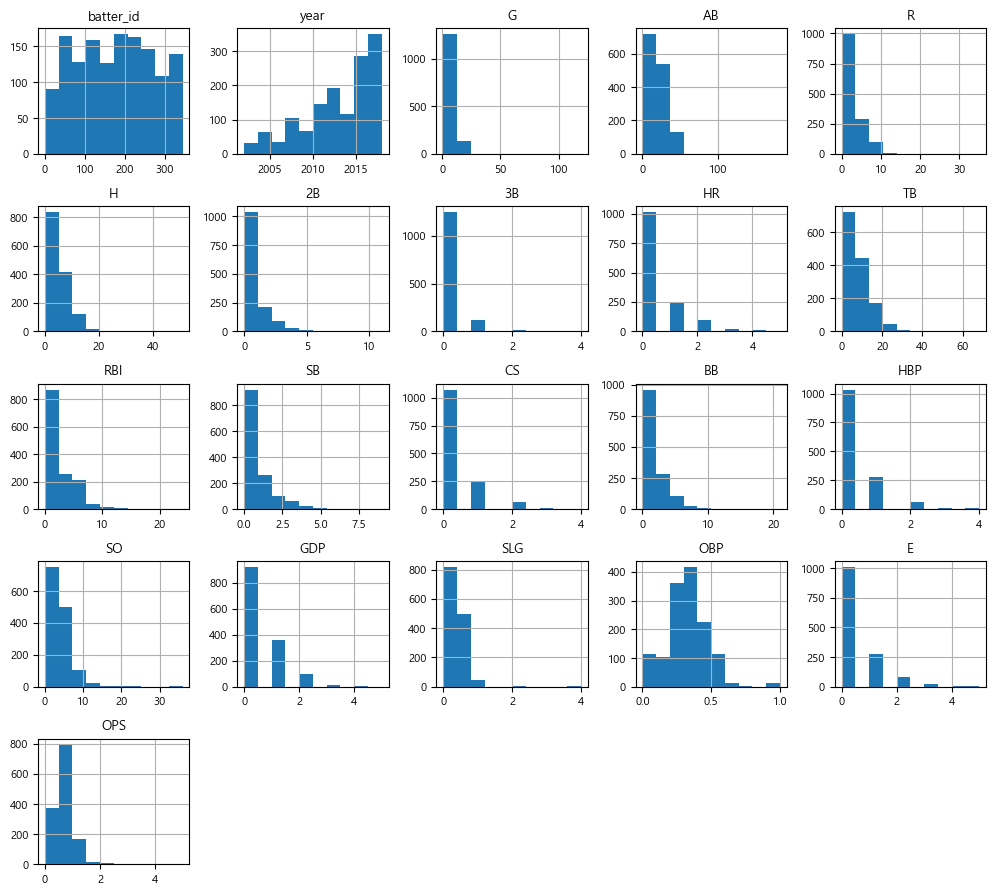

In [6]:
# 데이터 시각화
# 수치형 변수에 대해 히스토그램으로 분포 살펴보기
preseason_df.hist(figsize=(10,9))
# 그래프 간격 설정
plt.tight_layout()
plt.show()

수치형 변수의 데이터를 히스토그램으로 시각화한 결과,
* 2B, 3B ,AB, BB, CS, SLG, R, TB 등 대부분의 값이 0에 가까운 낮은 값을 기록했다.

  -> 프리시즌의 경기 수가 적어서 나타나는 현상이라고 추측할 수 있다.

* 2루타(2B), 3루타(3B), HBP(사구) 등의 기록을 보면 값의 범위가 매우 작게 형성되어 있다. 이 값들은 모두 0과 10 사이의 수치를 기록했다.

* 연도의 분포를 살펴보면 과거로 갈수록 기록의 수가 적어지는 것을 확인할 수 있다.

  -> 과거의 데이터일수록 기록한 데이터 수가 적다는 것을 의미한다.

* 분포를 살펴본 결과 프리시즌 데이터는 그 양이 부족한 상황.

#### 프리시즌 데이터를 정규시즌 데이터와 비교해서 살펴보기

In [7]:
# 정규시즌 데이터에서 2002년 이후의 연도별 기록된 선수의 수
regular_count = regular_season_df.groupby('year')['batter_id'].count().rename('regular')

In [8]:
# 프리시즌 데이터에서 연도별 기록된 선수의 수
preseason_count = preseason_df.groupby('year')['batter_id'].count().rename('preseason')

In [9]:
pd.concat([regular_count,preseason_count,
           np.round(preseason_count/regular_count,2).rename('ratio')],
          axis=1)
# 1993 ~ 2001년은 NaN으로 결측값. -> 2002년부터 보기
# 아래로 기니까 transpose 해서 보기

,regular,preseason,ratio
year,,,
1993,1,NaN,NaN
1994,2,NaN,NaN
1995,1,NaN,NaN
1996,7,NaN,NaN
1997,8,NaN,NaN
1998,10,NaN,NaN
1999,14,NaN,NaN
2000,20,NaN,NaN
2001,32,NaN,NaN


In [10]:
# 앞서 실행한 결과가 아래로 길어서 transpose 해서 보기
pd.concat([regular_count,preseason_count,
           np.round(preseason_count/regular_count,2).rename('ratio')],
          axis=1).T

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
regular,1.0,2.0,1.0,7.0,8.0,10.0,14.0,20.0,32.0,43.00,...,124.00,130.00,151.0,174.0,194.00,186.00,207.00,213.00,217.00,227.0
preseason,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.00,...,66.00,72.00,75.0,87.0,104.00,117.00,134.00,153.00,167.00,182.0
ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,...,0.53,0.55,0.5,0.5,0.54,0.63,0.65,0.72,0.77,0.8


In [11]:
# 앞서 실행한 결과가 아래로 길어서 transpose 해서 보기
pd.concat([regular_count,preseason_count,
           np.round(preseason_count/regular_count,2).rename('ratio')],
          axis=1).transpose()
# .T 와 .transpose()는 같은 결과

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
regular,1.0,2.0,1.0,7.0,8.0,10.0,14.0,20.0,32.0,43.00,...,124.00,130.00,151.0,174.0,194.00,186.00,207.00,213.00,217.00,227.0
preseason,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.00,...,66.00,72.00,75.0,87.0,104.00,117.00,134.00,153.00,167.00,182.0
ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,...,0.53,0.55,0.5,0.5,0.54,0.63,0.65,0.72,0.77,0.8


In [12]:
pd.concat([regular_count,preseason_count,
           np.round(preseason_count/regular_count,2).rename('ratio')],
          axis=1).T.loc[:,2002:]
# 2002년부터 보기

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
regular,43.00,54.00,68.00,73.00,85.00,98.00,115.00,124.00,130.00,151.0,174.0,194.00,186.00,207.00,213.00,217.00,227.0
preseason,12.00,19.00,28.00,37.00,36.00,43.00,61.00,66.00,72.00,75.0,87.0,104.00,117.00,134.00,153.00,167.00,182.0
ratio,0.28,0.35,0.41,0.51,0.42,0.44,0.53,0.53,0.55,0.5,0.5,0.54,0.63,0.65,0.72,0.77,0.8


In [13]:
# 프리시즌 성적과 정규시즌의 성적 간의 상관관계를 살펴보기 위해 
# 두 데이터에 공통적으로 존제하는 선수들의 기록만 정리하기
# -> 선수와 연도 데이터를 이용해 새로운 열을 생성하고
#    새로운 열의 교집합을 이용해 두 데이터셋에 모두 존재하는 선수만 불러오기

# 타자의 이름과 연도를 이용해 새로운 인덱스를 생성
regular_season_df['new_idx'] = regular_season_df['batter_name'] + regular_season_df['year'].apply(str)
preseason_df['new_idx'] = preseason_df['batter_name'] + preseason_df['year'].apply(str)

In [14]:
# 새로운 인덱스의 교집합
intersection_idx = set(regular_season_df['new_idx']).intersection(preseason_df['new_idx'])
# intersection_idx
len(intersection_idx)

1358

In [15]:
# 교집합에 존재하는 데이터만 불러오기
regular_season_new = regular_season_df.loc[regular_season_df['new_idx'].apply(lambda x:x in intersection_idx)].copy()
regular_season_new

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,가르시아2018
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2011
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,강경학2014
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,강경학2015
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,342,황재균,2014,롯데,0.321,128,486,66,156,33,...,0.475,0.388,16,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.863,황재균2014
2442,342,황재균,2015,롯데,0.290,144,534,95,155,41,...,0.521,0.350,16,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.871,황재균2015
2443,342,황재균,2016,롯데,0.335,127,498,97,167,26,...,0.570,0.394,15,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.964,황재균2016
2444,342,황재균,2018,KT,0.296,142,530,76,157,41,...,0.526,0.358,17,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.884,황재균2018


In [16]:
regular_season_new = regular_season_new.sort_values(by='new_idx')
regular_season_new

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,가르시아2018
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2011
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,강경학2014
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,강경학2015
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,342,황재균,2014,롯데,0.321,128,486,66,156,33,...,0.475,0.388,16,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.863,황재균2014
2442,342,황재균,2015,롯데,0.290,144,534,95,155,41,...,0.521,0.350,16,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.871,황재균2015
2443,342,황재균,2016,롯데,0.335,127,498,97,167,26,...,0.570,0.394,15,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.964,황재균2016
2444,342,황재균,2018,KT,0.296,142,530,76,157,41,...,0.526,0.358,17,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.884,황재균2018


In [17]:
regular_season_new = regular_season_new.sort_values(by='new_idx').reset_index(drop=True)
regular_season_new

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,가르시아2018
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2011
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,강경학2014
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,강경학2015
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,342,황재균,2014,롯데,0.321,128,486,66,156,33,...,0.475,0.388,16,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.863,황재균2014
1354,342,황재균,2015,롯데,0.290,144,534,95,155,41,...,0.521,0.350,16,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.871,황재균2015
1355,342,황재균,2016,롯데,0.335,127,498,97,167,26,...,0.570,0.394,15,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.964,황재균2016
1356,342,황재균,2018,KT,0.296,142,530,76,157,41,...,0.526,0.358,17,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.884,황재균2018


In [18]:
# 비교를 위해 인덱스로 정렬
# 비교를 위해 preseason 데이터도 동일하게 처리하기
preseason_new = preseason_df.loc[preseason_df['new_idx'].apply(lambda x:x in intersection_idx)].copy()
preseason_new

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959,가르시아2018
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500,강경학2011
2,1,강경학,2014,한화,-,4,0,2,0,0,...,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN,강경학2014
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416,강경학2015
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,342,황재균,2014,롯데,0.407,10,27,3,11,2,...,0.593,0.448,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,1.041,황재균2014
1389,342,황재균,2015,롯데,0.333,11,30,8,10,3,...,0.433,0.389,0,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.822,황재균2015
1390,342,황재균,2016,롯데,0.310,16,42,8,13,3,...,0.429,0.370,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.799,황재균2016
1391,342,황재균,2018,KT,0.250,6,16,3,4,1,...,0.500,0.333,3,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.833,황재균2018


In [19]:
preseason_new = preseason_new.sort_values(by='new_idx')
preseason_new

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959,가르시아2018
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500,강경학2011
2,1,강경학,2014,한화,-,4,0,2,0,0,...,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN,강경학2014
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416,강경학2015
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,342,황재균,2014,롯데,0.407,10,27,3,11,2,...,0.593,0.448,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,1.041,황재균2014
1389,342,황재균,2015,롯데,0.333,11,30,8,10,3,...,0.433,0.389,0,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.822,황재균2015
1390,342,황재균,2016,롯데,0.310,16,42,8,13,3,...,0.429,0.370,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.799,황재균2016
1391,342,황재균,2018,KT,0.250,6,16,3,4,1,...,0.500,0.333,3,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.833,황재균2018


In [20]:
preseason_new = preseason_new.sort_values(by='new_idx').reset_index(drop=True)
preseason_new

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959,가르시아2018
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500,강경학2011
2,1,강경학,2014,한화,-,4,0,2,0,0,...,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN,강경학2014
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416,강경학2015
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,342,황재균,2014,롯데,0.407,10,27,3,11,2,...,0.593,0.448,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,1.041,황재균2014
1354,342,황재균,2015,롯데,0.333,11,30,8,10,3,...,0.433,0.389,0,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.822,황재균2015
1355,342,황재균,2016,롯데,0.310,16,42,8,13,3,...,0.429,0.370,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.799,황재균2016
1356,342,황재균,2018,KT,0.250,6,16,3,4,1,...,0.500,0.333,3,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.833,황재균2018


In [21]:
# 검정 코드
print(regular_season_new.shape, preseason_new.shape)
sum(regular_season_new['new_idx'] == regular_season_new['new_idx'])

(1358, 30) (1358, 30)


1358

In [22]:
# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_new['OPS'].corr(preseason_new['OPS'])
correlation

0.14872584643104408

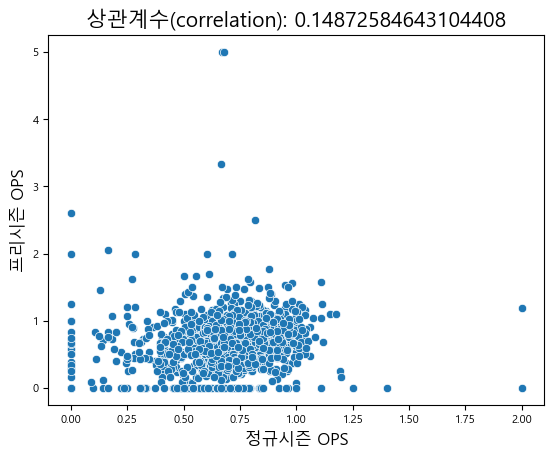

In [23]:
sns.scatterplot(x=regular_season_new['OPS'], y=preseason_new['OPS'])
plt.title('상관계수(correlation): '+str(correlation), fontsize=15)
plt.xlabel('정규시즌 OPS', fontsize=12)
plt.ylabel('프리시즌 OPS', fontsize=12)
plt.show()

* 정규시즌과 프리시즌의 성적 분포를 보면 선형적이지 않다.

-> 정규시즌 데이터와 프리시즌 데이터가 서로 상관성이 매우 낮다는 것을 의미함.

-------------------------

[ 탐색적 데이터 분석을 통해 알아낸 두 가지 사실 ]

1. 프리시즌 데이터의 경기 기록 수는 매우 적으므로 그 구성 역시 정규시즌 데이터와는 차이가 있을 수 있다.

2. 프리시즌 데이터와 정규시즌 데이터 간 상관관계가 매우 낮다.

=> 이를 종합해보면, 실제 분석에서는 프리시즌 데이터를 분석에서 제외할 것이다.

이번 대회의 예측 대상은 정규시즌의 성적이기 때문에, 프리시즌 데이터를 이용하지 않는 것이 더 정밀한 결과를 도출할 것이기 때문이다.

### 1.2.2. 정규시즌 데이터 분석

#### 정규시즌 데이터의 기초 통계량 살펴보기

In [24]:
regular_season_df.shape

(2454, 30)

In [25]:
regular_season_df.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,가르시아2018
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2011
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,강경학2014
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,강경학2015
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,강경학2016


In [26]:
regular_season_df.describe()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,...,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2428.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,...,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2428.000000,2430.000000,2454.000000,2428.000000
mean,178.079462,2011.614507,0.237559,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,...,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.343826,0.306684,3.676447,0.649939
std,97.557947,4.992833,0.098440,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,...,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.163335,0.111778,4.585248,0.261634
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.203000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.267454,0.272727,0.000000,0.546000
50%,183.000000,2013.000000,0.255000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,...,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.360124,0.328592,2.000000,0.688637
75%,265.000000,2016.000000,0.291000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,...,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.436000,0.367000,5.000000,0.797234
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,...,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


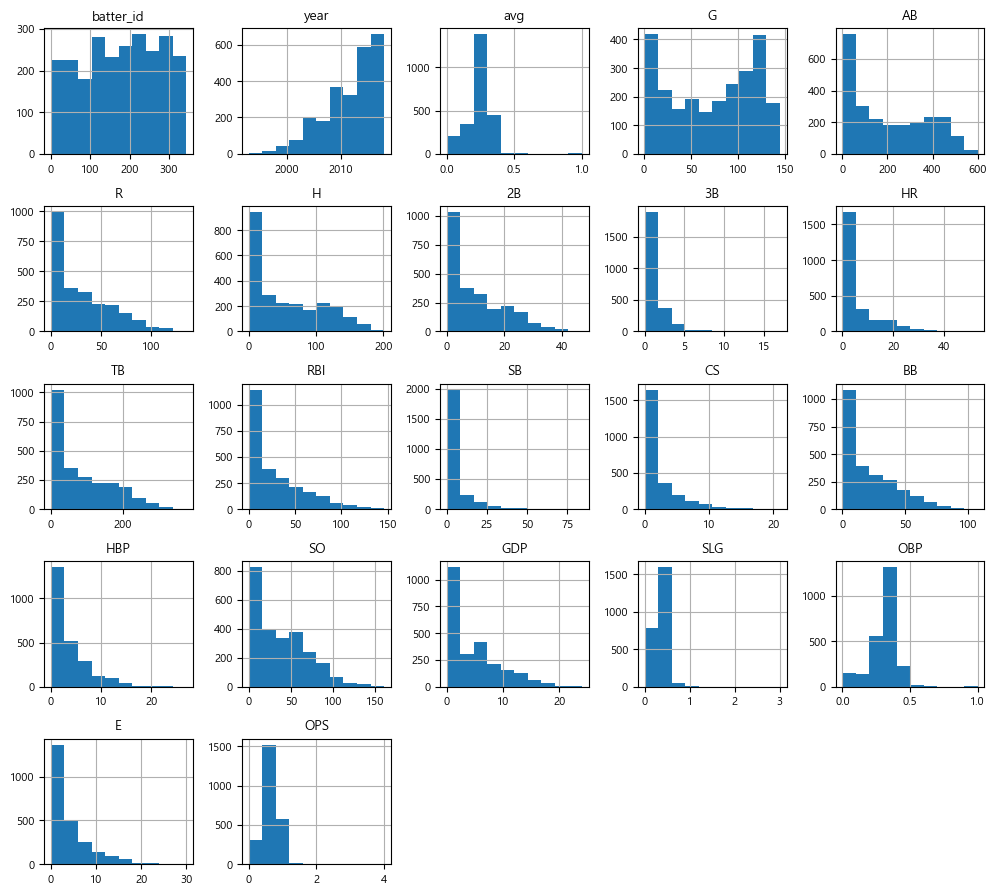

In [27]:
# 정규시즌 데이터 시각화
# 수치형 변수에 대해 히스토그램으로 분포 살펴보기
regular_season_df.hist(figsize=(10,9))
# 그래프 간격 설정
plt.tight_layout()
plt.show()

몇몇 변수가 0에 매우 치우쳐 있긴 하지만, 프리시즌 데이터와 비교했을 때 값의 범위가 더 넓어졌다.

또한 값들이 상대적으로 더 오른쪽으로 퍼져 있다.

이번 대회의 예측 대상인 OPS를 살펴보면 0 ~ 4 사이의 값을 갖고 대부분의 값이 1 이하인 것을 확인할 수 있다.

#### 박스그림(box plot)을 통해 OPS를 상세하게 살펴보기

<Axes: xlabel='year', ylabel='OPS'>

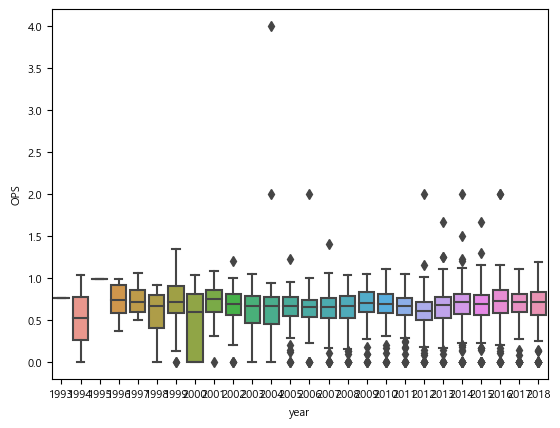

In [28]:
sns.boxplot(x='year',y='OPS',data=regular_season_df)

<Axes: xlabel='year', ylabel='OPS'>

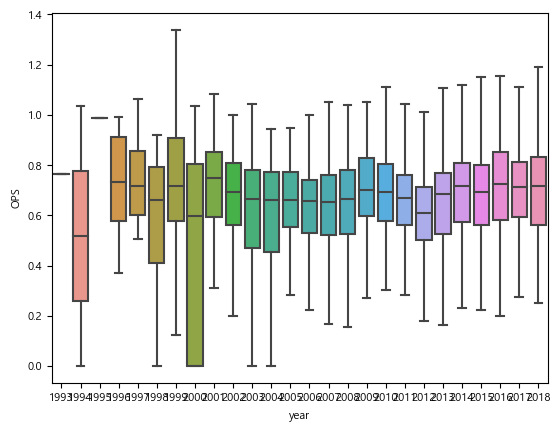

In [29]:
sns.boxplot(x='year', y='OPS', data=regular_season_df, showfliers=False)
# showfliers = False
# If False, suppress the plotting of outliers.
# -> 박스 범위를 벗어난 outlier를 표시하지 않음

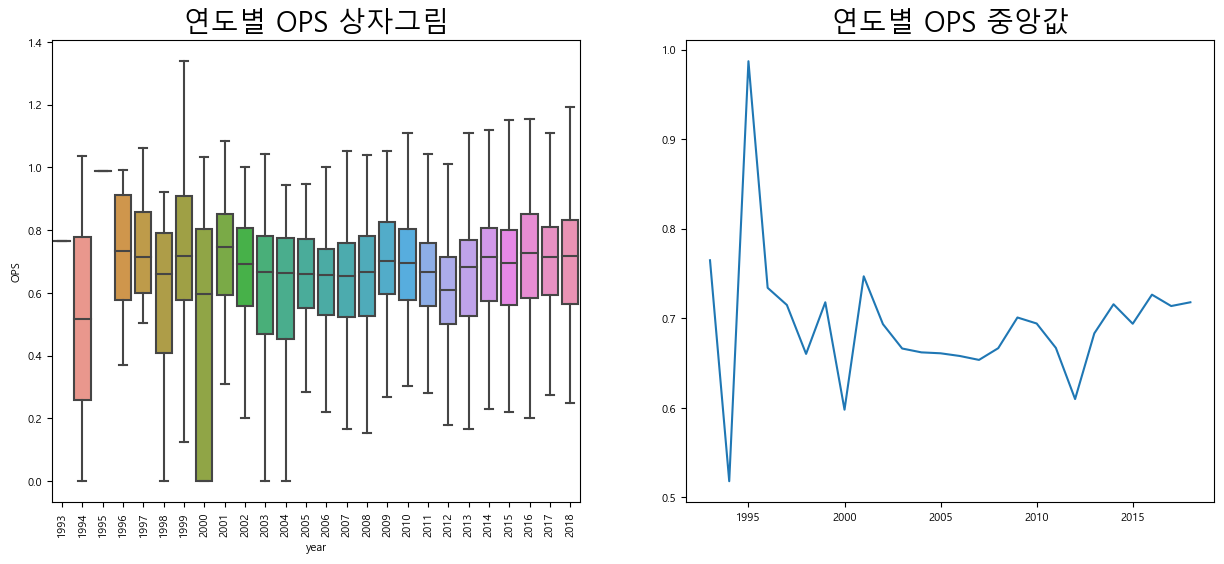

In [30]:
plt.figure(figsize=(15,6))  # 그래프 크기 조정
plt.subplot(1,2,1)  # 1행 2열의 첫 번째 (1행, 1열) 그래프

g = sns.boxplot(x='year', y='OPS', data=regular_season_df, showfliers=False)
g.set_title('연도별 OPS 상자그림', size=20)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.subplot(1,2,2)   # 1행 2열의 두 번째 (1행, 2열) 그래프
plt.plot(regular_season_df.groupby('year')['OPS'].median())
plt.title('연도별 OPS 중앙값', size=20)
plt.show()

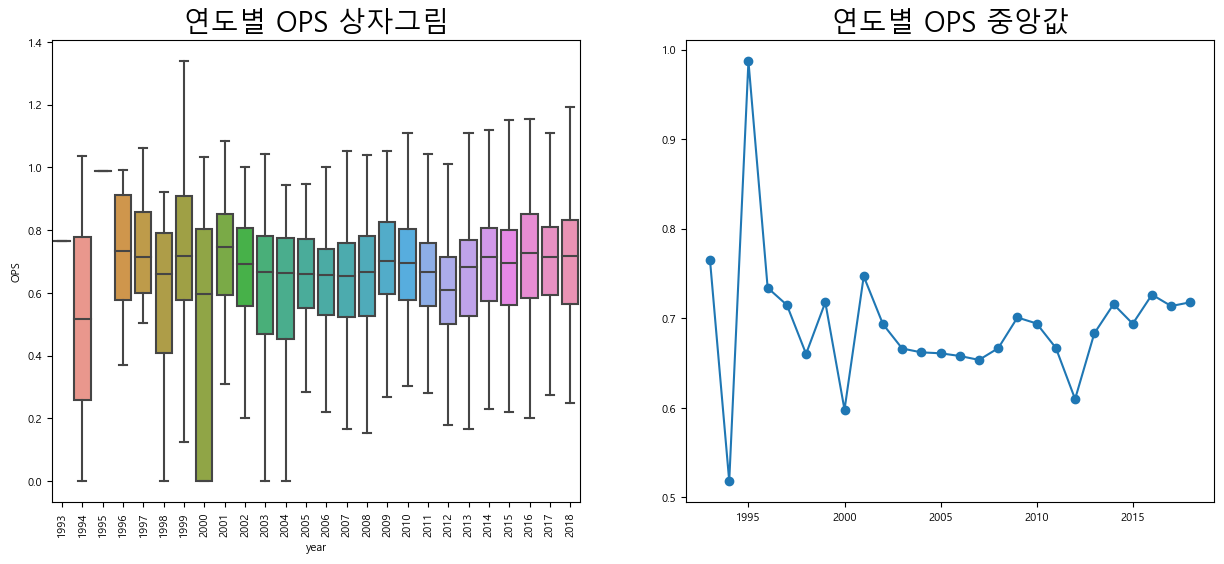

In [31]:
plt.figure(figsize=(15,6))  # 그래프 크기 조정
plt.subplot(1,2,1)  # 1행 2열의 첫 번째 (1행, 1열) 그래프

g = sns.boxplot(x='year', y='OPS', data=regular_season_df, showfliers=False)
g.set_title('연도별 OPS 상자그림', size=20)
# x축의 라벨을 90도 회전하기
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.subplot(1,2,2)   # 1행 2열의 두 번째 (1행, 2열) 그래프
plt.plot(regular_season_df.groupby('year')['OPS'].median(), marker='o')
# marker='o' : circle marker (동그라미 마크 표시)
plt.title('연도별 OPS 중앙값', size=20)
plt.show()

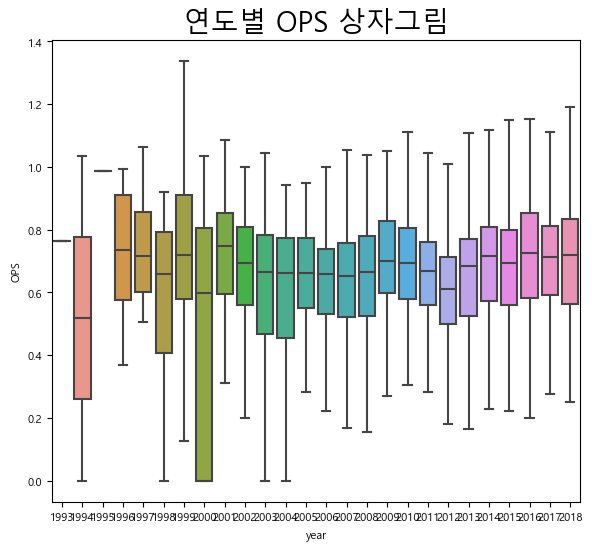

In [32]:
plt.figure(figsize=(15,6))  # 그래프 크기 조정
plt.subplot(1,2,1)  # 1행 2열의 첫 번째 (1행, 1열) 그래프

g = sns.boxplot(x='year', y='OPS', data=regular_season_df, showfliers=False)
g.set_title('연도별 OPS 상자그림', size=20)
# x축의 라벨을 90도 회전하는 코드를 지우고
# 기본값을 확인해보면 다음과 같다.
g.set_xticklabels(g.get_xticklabels())
plt.show()

연도별 OPS의 분포를 상자그림을 통해 확인한 결과, 대부분 비슷한 형태를 띠고 있다.

하지만 연도별 중앙값을 살펴보면, 2000년도를 기준으로 OPS의 변동이 차이가 있다.

2000년도 이전의 기록은 변동이 상당히 크며, 그 이후로는 상대적으로 변동폭이 크지 않은 추세를 보인다.

연도에 따라 데이터에 다소 차이가 있으므로, 연도별 OPS에 대해 조금 더 자세히 살펴볼 필요가 있다.

In [33]:
# 도수분포표
# 정규시즌의 연도별 카운트
pd.crosstab(regular_season_df['year'], 'count').T
# 그냥 실행하니까 결과가 아래로 길어서 
# transpose 해서 보기

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
col_0,,,,,,,,,,,,,,,,,,,,,
count,1,2,1,7,8,10,14,20,32,43,...,124,130,151,174,194,186,207,213,217,227


-> 2000년도 이전에는 기록의 수가 매우 적었다.

-> 모든 연도에서 20개 이하의 기록을 보유하고 있다.

=> 이 때문에 2000년도 이전 OPS의 변동 폭이 컸던 것임을 유추할 수 있다.

----------------------------------

선수들의 성적은 팀의 성적에도 영향을 받을 수 있다.

따라서 OPS 파악의 마지막 단계로 팀별 및 연도별 OPS의 값을 살펴보자.

In [34]:
# 연도별 팀의 OPS 중앙값 계산
med_OPS_team = regular_season_df.pivot_table(index=['team'], columns='year', values='OPS', aggfunc='median')
med_OPS_team

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
team,,,,,,,,,,,,,,,,,,,,,
KIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.849337,0.829906,...,0.707000,0.725000,0.680963,0.615420,0.679763,0.751196,0.598500,0.777000,0.777000,0.7320
KT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.643561,0.634500,0.710791,0.6550
LG,NaN,0.000000,NaN,0.476212,0.679836,0.509843,0.637173,0.689250,0.698978,0.645345,...,0.704000,0.677000,0.626000,0.552501,0.653000,0.680809,0.678000,0.729000,0.703000,0.7040
NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.652500,0.636742,0.711000,0.703000,0.705000,0.6000
OB,NaN,NaN,NaN,NaN,0.615797,0.727667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.596491,0.393000,...,0.822977,0.689176,0.710000,0.666953,0.689636,0.751500,0.714000,0.798500,0.764796,0.7685
넥센,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.636166,0.623000,0.589000,0.671000,0.792032,0.753000,0.800500,0.743500,0.7650
두산,NaN,NaN,NaN,NaN,NaN,NaN,0.853830,0.739755,0.695808,0.762809,...,0.701938,0.780000,0.733000,0.660000,0.781500,0.702330,0.760000,0.763000,0.685000,0.8230
롯데,NaN,NaN,NaN,NaN,NaN,NaN,1.124961,0.453390,0.577847,0.577000,...,0.680000,0.653000,0.676715,0.581845,0.600000,0.689000,0.622000,0.704000,0.728000,0.7100


In [35]:
med_OPS_team.loc[:,2005:]

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
team,,,,,,,,,,,,,,
KIA,0.583333,0.717176,0.546944,0.644474,0.707000,0.725000,0.680963,0.615420,0.679763,0.751196,0.598500,0.777000,0.777000,0.7320
KT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.643561,0.634500,0.710791,0.6550
LG,0.657000,0.593128,0.661500,0.622015,0.704000,0.677000,0.626000,0.552501,0.653000,0.680809,0.678000,0.729000,0.703000,0.7040
NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.652500,0.636742,0.711000,0.703000,0.705000,0.6000
OB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SK,0.601000,0.682591,0.774000,0.693000,0.822977,0.689176,0.710000,0.666953,0.689636,0.751500,0.714000,0.798500,0.764796,0.7685
넥센,NaN,NaN,NaN,NaN,NaN,0.636166,0.623000,0.589000,0.671000,0.792032,0.753000,0.800500,0.743500,0.7650
두산,0.699575,0.639750,0.656000,0.702000,0.701938,0.780000,0.733000,0.660000,0.781500,0.702330,0.760000,0.763000,0.685000,0.8230
롯데,0.673000,0.586748,0.629000,0.725455,0.680000,0.653000,0.676715,0.581845,0.600000,0.689000,0.622000,0.704000,0.728000,0.7100


In [36]:
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
med_OPS_team.loc[:,2005:].isna()

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
team,,,,,,,,,,,,,,
KIA,False,False,False,False,False,False,False,False,False,False,False,False,False,False
KT,True,True,True,True,True,True,True,True,True,True,False,False,False,False
LG,False,False,False,False,False,False,False,False,False,False,False,False,False,False
NC,True,True,True,True,True,True,True,True,False,False,False,False,False,False
OB,True,True,True,True,True,True,True,True,True,True,True,True,True,True
SK,False,False,False,False,False,False,False,False,False,False,False,False,False,False
넥센,True,True,True,True,True,False,False,False,False,False,False,False,False,False
두산,False,False,False,False,False,False,False,False,False,False,False,False,False,False
롯데,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [37]:
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
med_OPS_team.loc[:,2005:].isna().sum(axis=1)

team
KIA      0
KT      10
LG       0
NC       8
OB      14
SK       0
넥센       5
두산       0
롯데       0
삼성       0
쌍방울     14
우리      13
한화       0
해태      14
현대      11
히어로즈    13
dtype: int64

In [38]:
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
med_OPS_team.loc[:,2005:].isna().sum(axis=1) <= 0

team
KIA      True
KT      False
LG       True
NC      False
OB      False
SK       True
넥센      False
두산       True
롯데       True
삼성       True
쌍방울     False
우리      False
한화       True
해태      False
현대      False
히어로즈    False
dtype: bool

In [39]:
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
team_idx = med_OPS_team.loc[:,2005:].isna().sum(axis=1) <= 0
team_idx

team
KIA      True
KT      False
LG       True
NC      False
OB      False
SK       True
넥센      False
두산       True
롯데       True
삼성       True
쌍방울     False
우리      False
한화       True
해태      False
현대      False
히어로즈    False
dtype: bool

In [40]:
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
team_idx = med_OPS_team.loc[:,2005:].isna().sum(axis=1) <= 0
team_idx

team
KIA      True
KT      False
LG       True
NC      False
OB      False
SK       True
넥센      False
두산       True
롯데       True
삼성       True
쌍방울     False
우리      False
한화       True
해태      False
현대      False
히어로즈    False
dtype: bool

In [41]:
data = med_OPS_team.loc[team_idx,2005:].T
data

team,KIA,LG,SK,두산,롯데,삼성,한화
year,,,,,,,
2005,0.583333,0.657000,0.601000,0.699575,0.673000,0.741419,0.577151
2006,0.717176,0.593128,0.682591,0.639750,0.586748,0.734067,0.624351
2007,0.546944,0.661500,0.774000,0.656000,0.629000,0.602000,0.665602
2008,0.644474,0.622015,0.693000,0.702000,0.725455,0.681104,0.562049
2009,0.707000,0.704000,0.822977,0.701938,0.680000,0.694336,0.672000
2010,0.725000,0.677000,0.689176,0.780000,0.653000,0.771000,0.628597
2011,0.680963,0.626000,0.710000,0.733000,0.676715,0.677606,0.649190
2012,0.615420,0.552501,0.666953,0.660000,0.581845,0.614071,0.583929
2013,0.679763,0.653000,0.689636,0.781500,0.600000,0.721250,0.616000


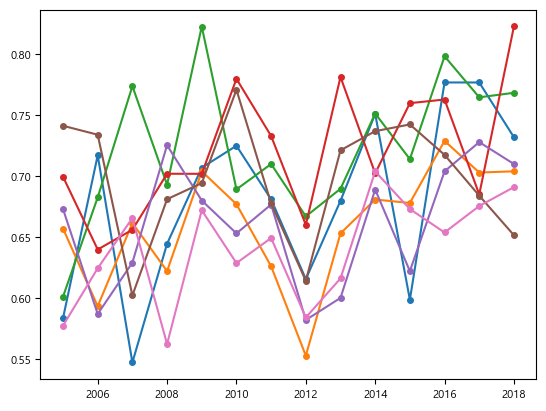

In [42]:
plt.plot(data, marker='o', markersize=4)
plt.show()

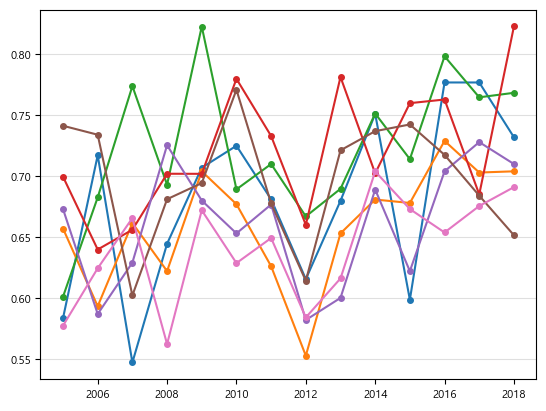

In [43]:
plt.plot(data, marker='o', markersize=4)
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.show()

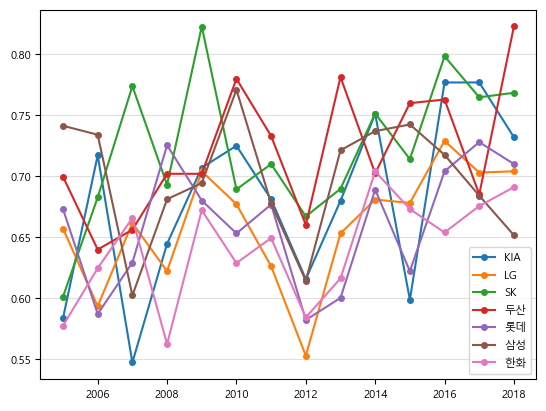

In [44]:
plt.plot(data, marker='o', markersize=4)
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.legend(data.columns)
plt.show()

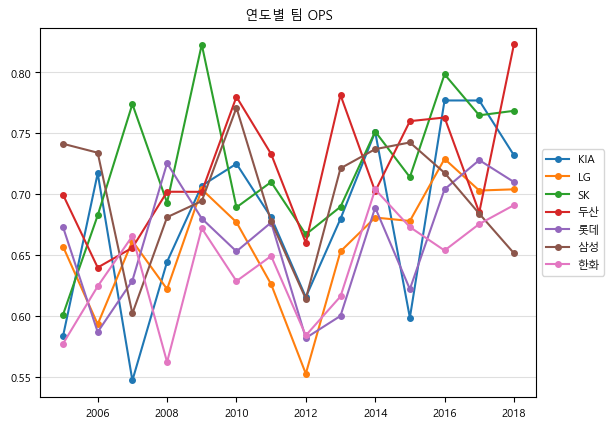

In [45]:
plt.plot(data, marker='o', markersize=4)
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.legend(data.columns, loc='center left', bbox_to_anchor=(1, 0.5))
# bbox_to_anchor : 그래프 범례를 그래프 밖에 위치시키기
plt.title('연도별 팀 OPS')
# plt.title('팀별 성적')
plt.show()

신생팀이 아닌, 과거에 데이터를 가지고 있는 팀들을 대상으로 연도별 팀 성적을 비교했다. 연도별 팀의 성적을 확인해보면, 성적이 계속 달라지고 순위도 변동되는 것을 확인할 수 있다.

#### 키와 몸무게 변수를 이용해 성적과 연관성이 있는지 살펴보기

In [46]:
import re

In [47]:
# 몸무게 값과 키의 값을 따로 얻기

In [48]:
regular_season_df['height/weight'].apply(lambda x: re.findall('\d+', x.split('/')[1])[0] if pd.notnull(x) else x)
# re.findall('\d+'): 하나 이상인 숫자를 모두 찾기

0       93
1       72
2       72
3       72
4       72
        ..
2449    82
2450    82
2451    82
2452    82
2453    82
Name: height/weight, Length: 2454, dtype: object

In [49]:
# re.findall()을 감싸는 괄호를 넣고 괄호 앞에 int() 붙이기.
regular_season_df['height/weight'].apply(lambda x: int(re.findall('\d+', x.split('/')[1])[0]) if pd.notnull(x) else x)

0       93.0
1       72.0
2       72.0
3       72.0
4       72.0
        ... 
2449    82.0
2450    82.0
2451    82.0
2452    82.0
2453    82.0
Name: height/weight, Length: 2454, dtype: float64

In [50]:
regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+', x.split('/')[0])[0]) if pd.notnull(x) else x)

0       177.0
1       180.0
2       180.0
3       180.0
4       180.0
        ...  
2449    181.0
2450    181.0
2451    181.0
2452    181.0
2453    181.0
Name: height/weight, Length: 2454, dtype: float64

--------------------------
#### re.findall('\d+') : 하나 이상인 숫자를 모두 찾기
--------------------------

키와 몸무게를 분리한 다음,

몸무게를 키로 나눠 새로운 변수 만들기

-> 이 값이 크면 그만큼 키에 비해 몸무게가 많이 나간다고 볼 수 있다.

일반적으로 키에 비해 몸무게가 크다면 힘이 셀 것이며,

반대의 경우에는 스피드가 빠를 것이라고 추측할 수 있다.

=> 따라서 계산한 값이 클 때는 힘과 연관성이 높은 장타율과의 상관관계를 보고,

값이 작을 때는 스피드가 중시되는 출루율과의 상관관계를 확인한다.

In [51]:
regular_season_df['weight'] = regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+', x.split('/')[1])[0]) if pd.notnull(x) else x)

regular_season_df['height'] = regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+', x.split('/')[0])[0]) if pd.notnull(x) else x)

In [52]:
print(regular_season_df['height/weight'][0], 
      regular_season_df['height'][0], 
      regular_season_df['weight'][0])

177cm/93kg 177.0 93.0


* 장타율(SLG): 타수에서 기대되는 평균 루타. Slugging Percentage.

* 출루율(OBP): 타수 대비 아웃되지 않고 1루로 출루한 비율. On Base Percentage.

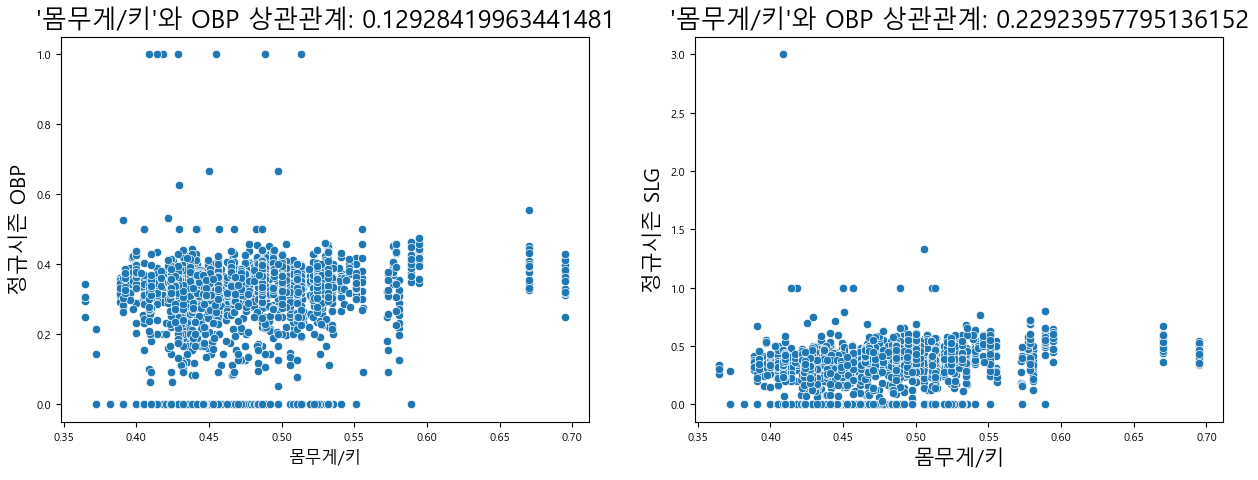

In [53]:
# 몸무게/키 계산
regular_season_df['weight_per_height'] = regular_season_df['weight']/regular_season_df['height']

plt.figure(figsize=(15,5))  # 그래프 크기 조정
plt.subplot(1,2,1)  # 1행 2열의 첫 번째 (1행, 1열) 그래프

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['OBP'])
correlation

sns.scatterplot(x=regular_season_df['weight_per_height'], y=regular_season_df['OBP'])
plt.title("'몸무게/키'와 OBP 상관관계: " +str(correlation), fontsize=18)
plt.ylabel('정규시즌 OBP', fontsize=15)
plt.xlabel('몸무게/키', fontsize=12)
plt.subplot(1,2,2)  # 1행 2열의 두 번째 (1행, 2열) 그래프

# 정규시즌과 프리시즌의 상관관계 계산
# 앞서 작성한 코드를 복사하여 작성
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['SLG'])
correlation

sns.scatterplot(x=regular_season_df['weight_per_height'], y=regular_season_df['SLG'])
plt.title("'몸무게/키'와 OBP 상관관계: " +str(correlation), fontsize=18)
plt.ylabel('정규시즌 SLG', fontsize=15)
plt.xlabel('몸무게/키', fontsize=15)
# plt.subplot(1,2,2)  # 1행 2열의 두 번째 (1행, 2열) 그래프

plt.show()

-> 데이터는 선형적인 모습을 띠지 않으며, 그 분포가 매우 고르게 분포되어 있음을 알 수 있다.

-> 몸무게 및 키가 장타율과 출루율에 큰 영향을 끼치지 않음을 의미한다.

#### 포지션과 관련한 기록 살펴보기

In [54]:
regular_season_df['position'].value_counts()

내야수(우투우타)    643
외야수(우투우타)    230
외야수(좌투좌타)    201
포수(우투우타)     189
외야수(우투좌타)    184
내야수(우투좌타)    141
내야수(좌투좌타)     36
포수(우투좌타)      14
외야수(우투양타)      7
내야수(우투양타)      7
Name: position, dtype: int64

-> 내야수, 외야수 등 수비 포지션을 의미하는 단어와

우투우타, 좌투좌타 등 타자가 주로 이용하는 손을 의미하는 단어가 섞여 있다.

=> 데이터를 더 자세하게 이해하기 위해 이 둘을 분리해보자.

In [55]:
# position
regular_season_df['pos'] = regular_season_df['position'].apply(
    lambda x:x.split('(')[0] if pd.notnull(x) else x)

# 우타, 좌타, 양타
regular_season_df['hit_way'] = regular_season_df['position'].apply(
    lambda x: x[-3:-1] if pd.notnull(x) else x)

print(regular_season_df['position'][0], 
      regular_season_df['pos'][0], 
      regular_season_df['hit_way'][0])

내야수(우투우타) 내야수 우타


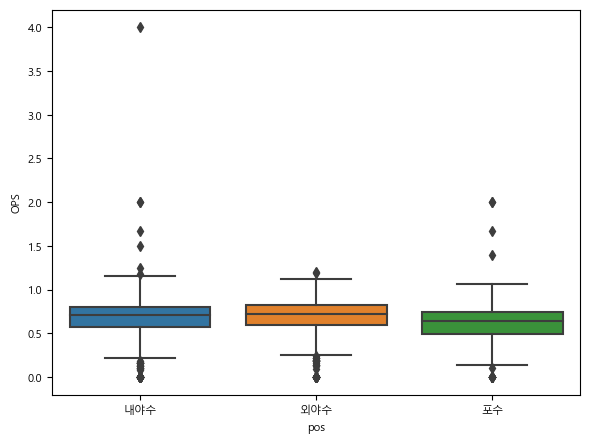

In [56]:
plt.figure(figsize=(15,5))  # 그래프 크기 조정
plt.subplot(1,2,1)  # 1행 2열의 첫 번째 (1행, 1열) 그래프
ax = sns.boxplot(x='pos', y='OPS', data=regular_season_df)

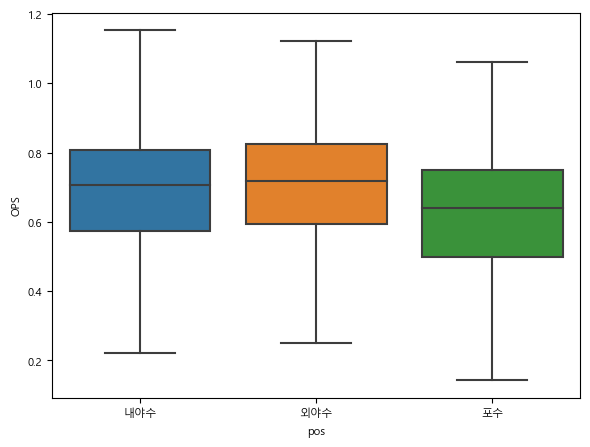

In [57]:
plt.figure(figsize=(15,5))  # 그래프 크기 조정
plt.subplot(1,2,1)  # 1행 2열의 첫 번째 (1행, 1열) 그래프
ax = sns.boxplot(x='pos', y='OPS', data=regular_season_df, showfliers=False)

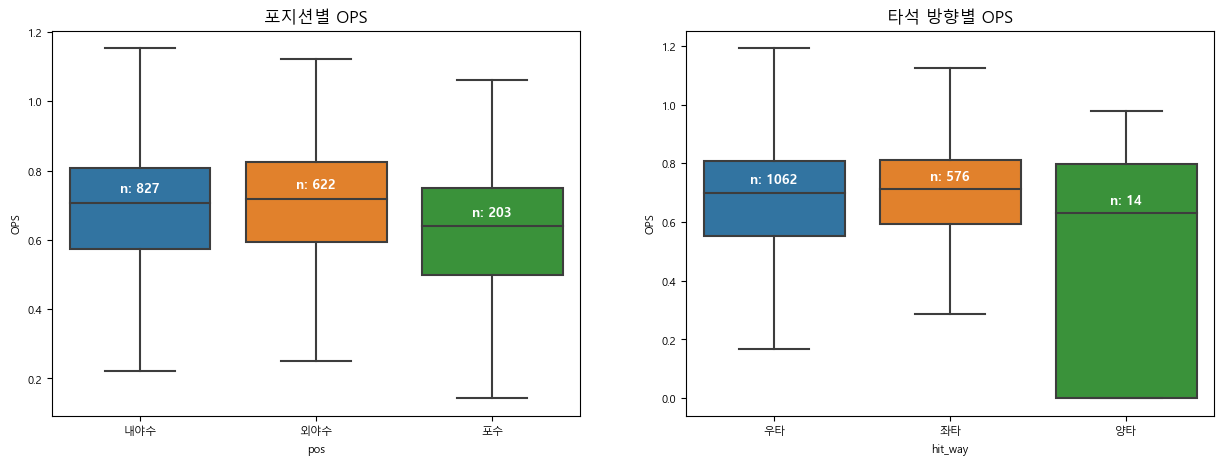

In [58]:
plt.figure(figsize=(15,5))  # 그래프 크기 조정
plt.subplot(1,2,1)  # 1행 2열의 첫 번째 (1행, 1열) 그래프
ax = sns.boxplot(x='pos', y='OPS', data=regular_season_df, showfliers=False)

# position 별 OPS 중앙값
medians = regular_season_df.groupby(['pos'])['OPS'].median().to_dict()

# position 별 관측치 수
nobs = regular_season_df['pos'].value_counts().to_dict()

# 키 값을 'n: 값' 형식으로 변환
for key in nobs:
    nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick는 tick의 위치, label은 그에 해당하는 text 값
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()), 
            medians[label.get_text()] + 0.03, 
            # 글씨가 중앙값과 겹치는 것을 방지하기 위해 살짝 띄워 준다.
            nobs[label.get_text()], 
            horizontalalignment='center', size='large', color='w', weight='semibold')

ax.set_title('포지션별 OPS', fontsize=12)


# 위에서 작성한 코드를 복사하여 작성함.
plt.subplot(1,2,2)  # 1행 2열의 두 번째 (1행, 2열) 그래프
ax = sns.boxplot(x='hit_way', y='OPS', data=regular_season_df, showfliers=False)

# 타자 방향별 OPS 중앙값
medians = regular_season_df.groupby(['hit_way'])['OPS'].median().to_dict()

# 타자 방향 관측치 수
nobs = regular_season_df['hit_way'].value_counts().to_dict()

# 키 값을 'n: 값' 형식으로 변환
for key in nobs:
    nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick는 tick의 위치, label은 그에 해당하는 text 값
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()), 
            medians[label.get_text()] + 0.03, 
            # 글씨가 중앙값과 겹치는 것을 방지하기 위해 살짝 띄워 준다.
            nobs[label.get_text()], 
            horizontalalignment='center', size='large', color='w', weight='semibold')

ax.set_title('타석 방향별 OPS', fontsize=12)
plt.show()

-> 포지션별로 OPS 값을 살펴본 결과, 내야수와 외야수의 성적은 큰 차이가 없다.

하지만 포수의 OPS는 다른 포지션보다 수치가 다소 작은 편이다.

즉, 포수를 제외하고 OPS 성적에는 포지션의 영향이 그리 크지 않다는 것을 의미한다.

또한 타자가 왼손잡이인지, 오른손잡이인지에 따른 OPS 값은 큰 차이가 없다.

양손잡이의 OPS가 다소 낮은 경향은 있으나, 그 관측치가 13개 밖에 되지 않아 이 결과를 신뢰하기는 어려울 것이다.

-------------------------

#### 커리어와 관련한 변수를 사용해 외국인과 내국인을 구별해 데이터 탐색하기

In [59]:
regular_season_df['career'].head()

0    쿠바 Ciego de Avila Maximo Gomez Baez(대)
1                         광주대성초-광주동성중-광주동성고
2                         광주대성초-광주동성중-광주동성고
3                         광주대성초-광주동성중-광주동성고
4                         광주대성초-광주동성중-광주동성고
Name: career, dtype: object

-> 주어진 데이터에서 career라고 표시된 값을 보면

한국인은 초등학교, 중학교, 고등학교에 대한 정보를 보유하고 있으며

외국인은 국가와 대학 순서로 정보를 보유하고 있다.

한국인의 경우 각 학교의 이름을 '-'로 구분하고 있으나 외국인은 이러한 형식을 띠고 있지 않다.

=> 따라서 '-'을 공백으로 대체하고 공백을 기준으로 데이터를 나눈다.

그리고 이를 바탕으로 career 정보를 세분화하여 데이터를 재구성해 탐색해본다.

In [60]:
# career를 split
foreign_country = regular_season_df['career'].apply(
    lambda x: x.replace('-', ' ').split(' ')[0])

In [61]:
# 외국만 추출
foreign_country_list = list(set(foreign_country.apply(
    lambda x: np.nan if '초' in x else x)))

In [62]:
# 결측치 처리
foreign_country_list = [x for x in foreign_country_list if str(x) != 'nan']
foreign_country_list

['미국', '캐나다', '쿠바', '네덜란드', '도미니카']

-> 캐나다, 쿠바, 미국, 네덜란드, 도미니카 국적을 가진 선수가 명단에 있다.

=> 해당하는 5개 국가의 국적에 속하는 선수들을 외국인으로 구분하고

이를 바탕으로 외국인과 내국인의 성적을 비교해보기

In [63]:
regular_season_df['country'] = foreign_country
regular_season_df['country'] = regular_season_df['country'].apply(
    lambda x: x if pd.isnull(x) 
                else ('foreign' if x in foreign_country_list else 'korean'))

regular_season_df[['country']].head()

,country
0,foreign
1,korean
2,korean
3,korean
4,korean


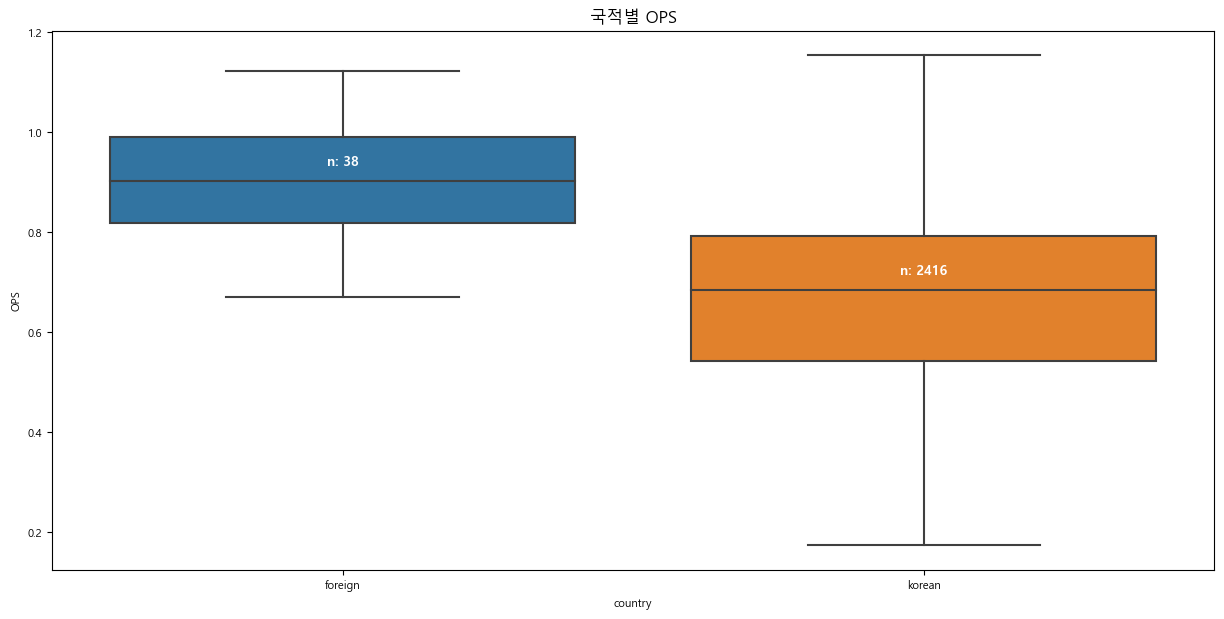

In [64]:
# 앞에서 작성한 코드를 복사하여 작성함.
plt.figure(figsize=(15,7))  # 그래프 크기 조정
ax = sns.boxplot(x='country', y='OPS', data=regular_season_df, showfliers=False)

#국적별 OPS 중앙값 dict
medians = regular_season_df.groupby(['country'])['OPS'].median().to_dict()

# 내외국인 관측치 수
nobs = regular_season_df['country'].value_counts().to_dict()

# 키 값을 'n: 값' 형식으로 변환
for key in nobs:
    nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

for label in ax.get_xticklabels():
    # tick은 tick의 위치, label은 그에 해당하는 text 값
    ax.text(xticks_labels.index(label.get_text()), 
            medians[label.get_text()] + 0.03, 
            # 글씨가 중앙값과 겹치는 것을 방지하기 위해 살짝 띄워 준다.
            nobs[label.get_text()],  # x 좌표, y 좌표, 해당 text
            horizontalalignment='center', size='large', color='w', weight='semibold')

ax.set_title('국적별 OPS', fontsize=12)
plt.show()

-> 비교 결과 외국인 선수들이 평균적으로 내국인 선수들보다 OPS 성적이 좋은 경향을 보인다.

In [65]:
regular_season_df['starting_salary'].value_counts()
# starting_salary: 첫 연봉
# 첫 연봉의 단위가 '달러'와 '만원'이 혼재해 있다.
# 달러로 연봉을 받았다면 외국인이라고 생각할 수 있다.

10000만원     177
6000만원      117
3000만원      105
9000만원       97
5000만원       91
8000만원       89
30000만원      74
4000만원       62
12000만원      62
18000만원      54
7000만원       53
11000만원      49
13000만원      48
20000만원      46
25000만원      45
15000만원      41
16000만원      28
14000만원      26
28000만원      20
43000만원      17
45000만원      16
27000만원      15
21000만원      13
23000만원      12
33000만원      10
6500만원       10
100000달러      4
300000달러      3
50000달러       2
17000만원       1
Name: starting_salary, dtype: int64

##### 외국인은 바로 전 단계에서 성적을 확인했으므로
##### 만 원 단위를 가진 첫 연봉의 데이터만 살펴보기

#### 결측치라면 그대로 0으로 두고 
#### '만원'이 포함되어 있다면 숫자만 뽑아서 초봉으로 넣어준다.

#### 그 외 만 원 단위가 아닌 초봉은 결측치로 처리한다.

In [66]:
regular_season_df['starting_salary'] = regular_season_df['starting_salary'].apply(
    lambda x: x if pd.isnull(x) 
                else(int(re.findall('\d+', x)[0]) if '만원' in x else np.nan))

C:\Users\admin\AppData\Local\Temp\ipykernel_12752\1340749475.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  b = sns.distplot(regular_season_df['starting_salary'].


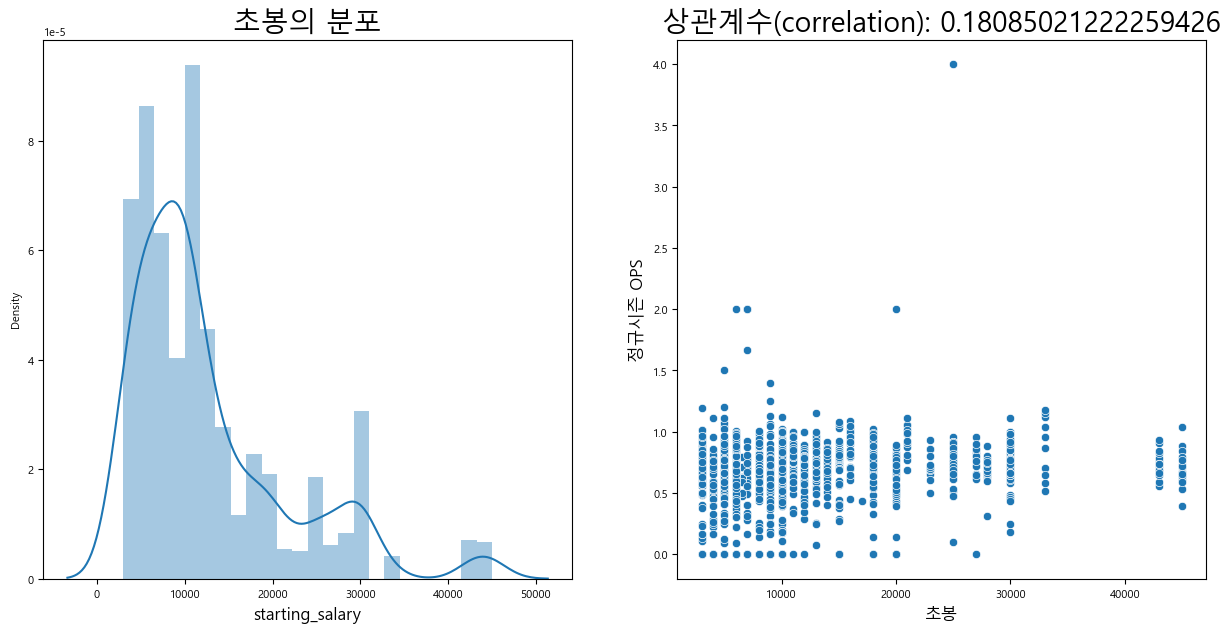

In [67]:
plt.figure(figsize=(15,7))  # 그래프 크기 조정
plt.subplot(1,2,1)  # 1행 2열의 첫 번째 (1행, 1열) 그래프

b = sns.distplot(regular_season_df['starting_salary'].
                 loc[regular_season_df['starting_salary'].notnull()], hist=True)

b.set_xlabel("starting_salary", fontsize=12)
b.set_title('초봉의 분포', fontsize=20)

plt.subplot(1,2,2)  # 1행 2열의 두 번째 (1행, 2열) 그래프

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['starting_salary'].corr(regular_season_df['OPS'])

# sns.scatterplot 사용할 때 꼭 () 안에 x=, y= 붙여줘야 함. 그렇지 않으면 오류 발생함.
b = sns.scatterplot(x=regular_season_df['starting_salary'], y=regular_season_df['OPS'])
b.axes.set_title('상관계수(correlation): ' + str(correlation), fontsize=20)
b.set_ylabel("정규시즌 OPS", fontsize=12)
b.set_xlabel("초봉", fontsize=12)
plt.show()

-> 확인 결과 첫 연봉과 성적은 큰 상관성을 보이지 않는다.

첫 연봉에 따른 성적은 왼쪽으로 약간 치우친 정규분포 형태를 보이고 상관관계는 0.18에 그쳤다.

### 정규시즌 데이터를 탐색한 결과

-> OPS 성적과 높은 연관성을 띠는 주어진 데이터에서의 변수가 매우 부족하다.

외국인 선수 OPS가 다소 높은 경향은 있으나, 외국인 선수는 매해 명단이 달라지며 그 숫자도 매우 부족해 분석에 적용하기에는 한계가 있다.

=> 주어진 데이터를 그대로 활용하는 것이 아니라 조금 다른 차원에서의 접근이 필요한 상황이다.

### 1.2.3. 일별 데이터 분석

In [70]:
# 날짜(date)를 ‘.’을 기준으로 나누고 첫 번째 값을 월(month)로 지정 


# 각 연도의 월별 평균 누적 타율(avg2) 계산


# pivot_table을 이용해 데이터 변형


<a id='m3'>연도별 월 평균 타율</a>

## 1.3. 데이터 전처리

In [71]:
# 수치형 타입의 변수 저장


# 수치형 타입 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출


In [72]:
# 수치형 변수에 포함되는 데이터 타입 선정


# 정규 시즌 데이터에서 결측치를 0으로 채우기


In [73]:
# 일별 데이터에서 결측치를 0으로 채우기


In [74]:
# 프리시즌 데이터에서 결측치를 0으로 채우기


In [75]:
# 수치형이 아닌 변수 추출


# 수치형이 아닌 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출


In [76]:
# 삭제할 데이터 추출
        

# 데이터 삭제


### 1.3.2. 규정 타수 정의

In [77]:
# OPS 이상치 탐색을 위한 수치 정의


# 실제 OPS 이상치 탐색


<a id='m4'>7월 일별 경기수 합</a>

In [78]:
# 7.01~7.31 숫자 생성 후 반 올림


### 1.3.3. 시간 변수

In [79]:
# 시간 변수를 생성하는 함수 정의


In [80]:
# 상관관계를 탐색할 변수 선택


In [81]:
# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출


In [82]:
# 상관관계 도출


In [83]:
# 상관관계의 시각적 표현


# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.



In [84]:
#희생 플라이 구하기
#OBP(출루율) 계산 공식 이용하여 SF(희생 플라이)계산 >> (H+BB+HBP)/OBP-(AB+BB+HBP)


#한 타수당 평균 희생 플라이 계산 후 필요한 것만 추출


In [85]:
#day_by_day에서 연도별 선수의 시즌 전반기 출루율과 관련된 성적 합 구하기

#day_by_day와 regular season에서 구한 희생 플라이 관련 데이터를 합치기

#선수별 전반기 희생 플라이 수 계산

#선수별 전반기 OBP(출루율) 계산

# OBP 결측치를 0으로 처리 

# 분석에 필요하지 않은 열 제거


### 1.3.4. 추가 변수 생성

<a id='m5'>나이별 평균 성적</a>

In [86]:
# 나이 변수 생성


In [87]:
# 나이, 평균 출루율, 출루율 중위값으로 구성된 데이터프레임 구축


In [88]:
# 나이에 따른 출루율 추이 시각화


In [89]:
# 나이를 포함한 변수 선택


# 총 3년 전 성적까지 변수를 생성


### 1.3.5. 데이터 사후 처리

In [90]:
# 결측치 비율 확인


In [91]:
#1. 선수별 OBP 평균
# SF = (H+BB+HBP) / OBP-(AB+BB+HBP)
# OBP = (H+BB+HBP) / (AB+BB+HBP+SF)


In [92]:
#2. 시즌별 OBP 평균


In [93]:
#### player_OBP_mean(선수평균) 열 추가


In [94]:
# 결측치 처리하는 함수 정의


In [95]:
# 생성한 함수를 이용해 결측치 처리 진행


### 1.3.6. SLG 데이터 전처리

In [96]:
# 상관관계를 탐색할 변수 선택


# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출

# 상관관계 도출


# 상관관계의 시각적 표현


# 대각 행렬을 기준으로 한쪽만 나타나게 설정해줍니다.



In [97]:
# day_by_day에서 연도별 선수의 시즌 전반기 장타율(SLG)과 관련된 성적 합 구하기

# 전반기 장타율 계산

# SLG 결측치를 0으로 처리 

# 필요한 칼럼만 불러오고 나이 계산


In [98]:
# 총 3년 전 성적까지 변수를 생성


In [99]:
# 선수별 SLG 평균 데이터(player_SLG_mean)를 만듭니다


# 시즌별 SLG 평균 데이터(season_SLG_mean)를 만듭니다


# 선수 평균의 SLG(player_OBP_mean)를 새로운 변수로 더합니다.


# 선수 평균의 성적이 결측치이면 데이터에서 제거합니다.


# 결측치 처리



## 1.4. 모델링
### 1.4.1. 데이터 분할

In [100]:
# 30타수 이상의 데이터만 학습


# 2018년 데이터를 test 데이터 2018년 이전은 train 데이터로 나눈다.




### 1.4.2. 모델 선택

In [101]:


# log 단위(1e+01)로 1.e-04 ~ 1.e+01 사이의 구간에 대해 parameter를 탐색한다. 


# GridSearchCV를 이용하여 dict에 Lasso, Ridege OBP 모델을 저장한다.


# GridSearchCV를 이용하여 dict에 Lasso, Ridge SLG 모델을 저장한다


In [102]:


# 랜덤 포레스트의 parameter 범위를 정의한다.


# GridSearchCV를 이용하여 dict에 OBP Randomforest 모델을 저장한다.


# GridSearchCV를 이용하여 dict에 OBP Randomforest 모델을 저장한다.



In [103]:
# 테스트 데이터셋(2018년)의 선수들의 OBP를 예측

# XGB_OBP = XGB_OBP_gridsearch.predict(OBP_test.iloc[:,-5:])

# test 데이터의 WRMSE 계산

# 막대그래프 위에 값을 표시해준다.


In [104]:
# 테스트 데이터셋(2018년)의 선수들의 SLG를 예측


# test데이터 WRMSE 계산



### 1.4.3. 결과 해석과 평가

In [105]:
# Lasso에서 GridSearchCV로 탐색한 최적의 alpha값 출력


## 1.5. 성능 향상을 위한 방법
### 1.5.1. 앙상블

### 1.5.2. 단순화된 모델 생성

### 1.5.3. 테스트 데이터 정제

### 1.5.4. 반발계수의 변화